## <font color = 'darkblue'> **Sequência para chegar no melhor modelo**

1) Feito uma grande Análise Exploratória

2) Avaliando os dados geográficos com Geopandas

3) Desenvolvido notebook para o projeto de Machine Learning, com funções que podem facilitar testes de diferentes modelos

4) **Aprimorar o modelo de Machine Learning, seguindo as etapas abaixo:**
    - Linear Regression com preprocessamento só colunas categóricas, comparando com Dummy Regressor
    - Avaliado se a transformação de target melhorava modelo, e testado qual transformação de target era melhor (PowerTransform ou Quantile Transform)
    - **Testado diferentes preprocessamento para colunas numéricas (só RobustScaler ou Standard Scaler + Power Transform) com a melhor transformação de target anterior**
    - Aplicado Polynomial Features para verifical qual grau do modelo ficava melhor, apenas com Robust Scaler para colunas numéricas e QuantileTransform para o target
    - Substituído o Linear Regression pelo Elastic Net para verificar se alguma regularização melhorava o modelo
    - Substituído o ElasticNet pelo Ridge para verificar os resultado, definindo finalmente o melhor modelo

5) Salvar o melhor modelo

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OrdinalEncoder,
    OneHotEncoder,
    PolynomialFeatures,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
    QuantileTransformer,
)

from src.config import DADOS_LIMPOS
from src.auxiliares import dataframe_coeficientes
from src.graficos import (
    plot_coeficientes,
    plot_comparar_metricas_modelos,
    plot_residuos_estimador,
)
from src.models import (
    organiza_resultados,
    treinar_e_validar_modelo_regressao,
    grid_search_cv_regressor,
)

In [2]:
df = pd.read_parquet(DADOS_LIMPOS)

df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,median_income_cat,rooms_per_household,population_per_household,bedrooms_per_room
0,-122.230003,37.880001,41,880,129,322,126,8.3252,452600,NEAR BAY,5,6.984127,2.555556,0.146591
1,-122.220001,37.860001,21,7099,1106,2401,1138,8.3014,358500,NEAR BAY,5,6.238137,2.109842,0.155797
2,-122.260002,37.840000,42,2555,665,1206,595,2.0804,226700,NEAR BAY,2,4.294117,2.026891,0.260274
3,-122.260002,37.849998,50,1120,283,697,264,2.1250,140000,NEAR BAY,2,4.242424,2.640152,0.252679
4,-122.260002,37.840000,50,2239,455,990,419,1.9911,158700,NEAR BAY,2,5.343676,2.362768,0.203216


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17564 entries, 0 to 17563
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   longitude                 17564 non-null  float32 
 1   latitude                  17564 non-null  float32 
 2   housing_median_age        17564 non-null  int8    
 3   total_rooms               17564 non-null  int16   
 4   total_bedrooms            17564 non-null  int16   
 5   population                17564 non-null  int16   
 6   households                17564 non-null  int16   
 7   median_income             17564 non-null  float32 
 8   median_house_value        17564 non-null  int32   
 9   ocean_proximity           17564 non-null  category
 10  median_income_cat         17564 non-null  int64   
 11  rooms_per_household       17564 non-null  float32 
 12  population_per_household  17564 non-null  float32 
 13  bedrooms_per_room         17564 non-null  floa

#### **Fórmulas usadas para geração e avaliação dos modelos de machine learning deste projeto**

OBS: Expandir a célula abaixo caso queira consultar as fórmulas

In [ ]:
# Função para construir o pipeline do modelo d e regressão, caso exista ou não etapas de preprocessamento e transformação de target
def construir_pipeline_modelo_regressao(
    regressor, preprocessor=None, target_transformer=None
):
    if preprocessor is not None:
        pipeline = Pipeline([("preprocessor", preprocessor), ("reg", regressor)])
    else:
        pipeline = Pipeline([("reg", regressor)])

    if target_transformer is not None:
        model = TransformedTargetRegressor(
            regressor=pipeline, transformer=target_transformer
        )
    else:
        model = pipeline
    return model

# Função treinar o modelo de regressão e retornar os scores da validação cruzada
def treinar_e_validar_modelo_regressao(
    X,
    y,
    regressor,
    preprocessor=None,
    target_transformer=None,
    n_splits=5,
    random_state=RANDOM_STATE,
):

    model = construir_pipeline_modelo_regressao(
        regressor, preprocessor, target_transformer
    )

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    scores = cross_validate(
        model,
        X,
        y,
        cv=kf,
        scoring=[
            "r2",
            "neg_mean_absolute_error",
            "neg_root_mean_squared_error",
        ],
    )

    return scores

# Após aplicar a função "treinar_e_validar_modelo_regressao" é aplicado essa função para obter um dataframe com as métricas de avaliação do modelo de regressão de acordo com a validação cruzada
def organiza_resultados(resultados):

    for chave, valor in resultados.items():
        resultados[chave]["time_seconds"] = (
            resultados[chave]["fit_time"] + resultados[chave]["score_time"]
        )

    df_resultados = (
        pd.DataFrame(resultados).T.reset_index().rename(columns={"index": "model"})
    )

    df_resultados_expandido = df_resultados.explode(
        df_resultados.columns[1:].to_list()
    ).reset_index(drop=True)

    try:
        df_resultados_expandido = df_resultados_expandido.apply(pd.to_numeric)
    except ValueError:
        pass

    return df_resultados_expandido

# Após aplicar a função "organiza_resultados(resultados)" é aplicado essa função para transformar os dados do dataframe em 4 gráficos
def plot_comparar_metricas_modelos(df_resultados):
    fig, axs = plt.subplots(2, 2, figsize=(8, 8), sharex=True)

    comparar_metricas = [
        "time_seconds",
        "test_r2",
        "test_neg_mean_absolute_error",
        "test_neg_root_mean_squared_error",
    ]

    nomes_metricas = [
        "Tempo (s)",
        "R²",
        "MAE",
        "RMSE",
    ]

    for ax, metrica, nome in zip(axs.flatten(), comparar_metricas, nomes_metricas):
        sns.boxplot(
            x="model",
            y=metrica,
            data=df_resultados,
            ax=ax,
            showmeans=True,
        )
        ax.set_title(nome)
        ax.set_ylabel(nome)
        ax.tick_params(axis="x", rotation=90)

    plt.tight_layout()

    plt.show()

# Função criada para utilizar a ferramenta grid_search para obter quais são os melhores parâmetros para o modelo de machine learning
def grid_search_cv_regressor(
    regressor,
    param_grid,
    preprocessor=None,
    target_transformer=None,
    n_splits=5,
    random_state=RANDOM_STATE,
    return_train_score=False,
):
    model = construir_pipeline_modelo_regressao(
        regressor, preprocessor, target_transformer
    )

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    grid_search = GridSearchCV(
        model,
        cv=kf,
        param_grid=param_grid,
        scoring=["r2", "neg_mean_absolute_error", "neg_root_mean_squared_error"],
        refit="neg_root_mean_squared_error",
        n_jobs=-1,
        return_train_score=return_train_score,
        verbose=1,
    )

    return grid_search

# Após ter definido o melhor modelo, é aplicado essa formula para comparar os dados previstos com os dados de teste
def plot_residuos_estimador(estimator, X, y, eng_formatter=False, fracao_amostra=0.25):

    fig, axs = plt.subplots(1, 3, figsize=(12, 6))

    error_display_01 = PredictionErrorDisplay.from_estimator(
        estimator,
        X,
        y,
        kind="residual_vs_predicted",
        ax=axs[1],
        random_state=RANDOM_STATE,
        scatter_kwargs={"alpha": SCATTER_ALPHA},
        subsample=fracao_amostra,                       # Mostra o percentual dos dados que serão exibidos no gráfico
    )

    error_display_02 = PredictionErrorDisplay.from_estimator(
        estimator,
        X,
        y,
        kind="actual_vs_predicted",
        ax=axs[2],
        random_state=RANDOM_STATE,
        scatter_kwargs={"alpha": SCATTER_ALPHA},
        subsample=fracao_amostra,
    )

    residuos = error_display_01.y_true - error_display_01.y_pred

    sns.histplot(residuos, kde=True, ax=axs[0])

    if eng_formatter:                                              # É só pra melhorar a legenda dos eixos X e y, em vez de deixar 100000 e 20000 fica 100k e 200k
        for ax in axs:
            ax.yaxis.set_major_formatter(EngFormatter())
            ax.xaxis.set_major_formatter(EngFormatter())

    plt.tight_layout()

    plt.show()

#### **Separação das colunas do dataframe**

In [4]:
coluna_target = ['median_house_value']

coluna_one_hot_encoder = ['ocean_proximity']

coluna_ordinal_enconder = ['median_income_cat']

In [5]:
colunas_robust_scaler = df.columns.difference(coluna_target + coluna_one_hot_encoder + coluna_ordinal_enconder)
# Robust Scaler é parecido com o Standard Scaler, mas é menos sensível aos outliers. (Pelos boxplots do notebook da análise exploratório vimos que os dados tem bastante outliers)
# Foi escolhido para todas as colunas numéricas (que não são categóricas e nem o target). 

colunas_robust_scaler

Index(['bedrooms_per_room', 'households', 'housing_median_age', 'latitude',
       'longitude', 'median_income', 'population', 'population_per_household',
       'rooms_per_household', 'total_bedrooms', 'total_rooms'],
      dtype='object')

In [6]:
colunas_standard_scaler = ['latitude', 'longitude', 'housing_median_age']
# Foi escolhido o Standard Scaler para essas colunas porque elas não possuem outliers 

colunas_power_transformer = df.columns.difference(coluna_target + coluna_one_hot_encoder + coluna_ordinal_enconder + colunas_standard_scaler)
# Já para essas colunas elas possuem outliers e o standard scaler não é o mais indicado

In [7]:
X = df.drop(columns=coluna_target)
y = df[coluna_target]

#### **Definido o *Preprocessamento* e *Target Transformer* inicial**

In [8]:
preprocessamento_categoricas = ColumnTransformer(
    transformers = [
        ('one_hot_encoder', OneHotEncoder(drop='first'), coluna_one_hot_encoder),         # drop='first' --> Para reduzir o número de colunas no preprocessamento
        ('ordinal_encoder', OrdinalEncoder(categories='auto'), coluna_ordinal_enconder)
    ],
    remainder='passthrough'
)

preprocessamento_simples = ColumnTransformer(
    transformers = [
        ('one_hot_encoder', OneHotEncoder(drop='first'), coluna_one_hot_encoder),         # drop='first' --> Para reduzir o número de colunas no preprocessamento
        ('ordinal_encoder', OrdinalEncoder(categories='auto'), coluna_ordinal_enconder),
        ('robust_scaler', RobustScaler(), colunas_robust_scaler)      
    ],
)

preprocessamento_completo = ColumnTransformer(
    transformers = [
        ('one_hot_encoder', OneHotEncoder(drop='first'), coluna_one_hot_encoder),         # drop='first' --> Para reduzir o número de colunas no preprocessamento
        ('ordinal_encoder', OrdinalEncoder(categories='auto'), coluna_ordinal_enconder),
        ('standard_scaler', StandardScaler(), colunas_standard_scaler),
        ('power_transformer', PowerTransformer(), colunas_power_transformer)      
    ],
)

#### **Analisando qual preprocessamento e qual transformação de target é mais adequada pelo GridSearchCV*** 

In [9]:
param_grid = {
    'regressor__preprocessor': [preprocessamento_categoricas, preprocessamento_simples, preprocessamento_completo],
    'transformer' : [None, PowerTransformer(), QuantileTransformer(output_distribution='normal')]
}

In [10]:
grid_search = grid_search_cv_regressor(
    regressor= LinearRegression(),
    preprocessor = preprocessamento_completo,               # Valor padrão de preprocessamento, com o param_grid serão testados outros
    target_transformer = PowerTransformer(),                # Valor padrão de target_transform, com o param_grid serão testados outros
    param_grid = param_grid
)

grid_search

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('one_hot_encoder',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity']),
                                                                                                             ('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat']),
                                                                                                             ('standard_scaler',
                                                                                                              StandardScaler(),
                                                                                                              ['latitude',
                                                                                                               '...
                                                                                      Index(['bedrooms_per_room', 'households', 'median_income', 'population',
       'population_per_household', 'rooms_per_household', 'total_bedrooms',
       'total_rooms'],
      dtype='object'))])],
                         'transformer': [None, PowerTransformer(),
                                         QuantileTransformer(output_distribution='normal')]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

In [11]:
grid_search.fit(X, y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('one_hot_encoder',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity']),
                                                                                                             ('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat']),
                                                                                                             ('standard_scaler',
                                                                                                              StandardScaler(),
                                                                                                              ['latitude',
                                                                                                               '...
                                                                                      Index(['bedrooms_per_room', 'households', 'median_income', 'population',
       'population_per_household', 'rooms_per_household', 'total_bedrooms',
       'total_rooms'],
      dtype='object'))])],
                         'transformer': [None, PowerTransformer(),
                                         QuantileTransformer(output_distribution='normal')]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

In [12]:
grid_search.best_params_

{'regressor__preprocessor': ColumnTransformer(transformers=[('one_hot_encoder', OneHotEncoder(drop='first'),
                                  ['ocean_proximity']),
                                 ('ordinal_encoder', OrdinalEncoder(),
                                  ['median_income_cat']),
                                 ('robust_scaler', RobustScaler(),
                                  Index(['bedrooms_per_room', 'households', 'housing_median_age', 'latitude',
        'longitude', 'median_income', 'population', 'population_per_household',
        'rooms_per_household', 'total_bedrooms', 'total_rooms'],
       dtype='object'))]),
 'transformer': QuantileTransformer(output_distribution='normal')}

In [13]:
grid_search.best_score_         # Veja que ficou do que os RMSE de -55011.704377 do Linear Regression + Power Transformer

-54419.33338947084

In [14]:
grid_search.best_estimator_

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(transformers=[('one_hot_encoder',
                                                                                       OneHotEncoder(drop='first'),
                                                                                       ['ocean_proximity']),
                                                                                      ('ordinal_encoder',
                                                                                       OrdinalEncoder(),
                                                                                       ['median_income_cat']),
                                                                                      ('robust_scaler',
                                                                                       RobustScaler(),
                                                                                       Index(['bedrooms_per_room', 'households', 'housing_median_age', 'latitude',
       'longitude', 'median_income', 'population', 'population_per_household',
       'rooms_per_household', 'total_bedrooms', 'total_rooms'],
      dtype='object'))])),
                                                     ('reg',
                                                      LinearRegression())]),
                           transformer=QuantileTransformer(output_distribution='normal'))

In [15]:
grid_search.best_estimator_.regressor_['preprocessor'].get_feature_names_out()

array(['one_hot_encoder__ocean_proximity_INLAND',
       'one_hot_encoder__ocean_proximity_NEAR BAY',
       'one_hot_encoder__ocean_proximity_NEAR OCEAN',
       'ordinal_encoder__median_income_cat',
       'robust_scaler__bedrooms_per_room', 'robust_scaler__households',
       'robust_scaler__housing_median_age', 'robust_scaler__latitude',
       'robust_scaler__longitude', 'robust_scaler__median_income',
       'robust_scaler__population',
       'robust_scaler__population_per_household',
       'robust_scaler__rooms_per_household',
       'robust_scaler__total_bedrooms', 'robust_scaler__total_rooms'],
      dtype=object)

In [16]:
grid_search.best_estimator_.regressor_['reg'].coef_

array([-0.44811838, -0.2002398 , -0.05773305,  0.0339087 ,  0.24552086,
        0.27198665,  0.11904297, -1.07110968, -1.05785593,  0.79639626,
       -0.03383865, -0.23166312,  0.17861497, -0.08049158, -0.09675917])

In [17]:
coefs = dataframe_coeficientes(
    grid_search.best_estimator_.regressor_['reg'].coef_, 
    grid_search.best_estimator_.regressor_['preprocessor'].get_feature_names_out()
)

coefs

,coeficiente
robust_scaler__latitude,-1.071110
robust_scaler__longitude,-1.057856
one_hot_encoder__ocean_proximity_INLAND,-0.448118
robust_scaler__population_per_household,-0.231663
one_hot_encoder__ocean_proximity_NEAR BAY,-0.200240
robust_scaler__total_rooms,-0.096759
robust_scaler__total_bedrooms,-0.080492
one_hot_encoder__ocean_proximity_NEAR OCEAN,-0.057733
robust_scaler__population,-0.033839
ordinal_encoder__median_income_cat,0.033909


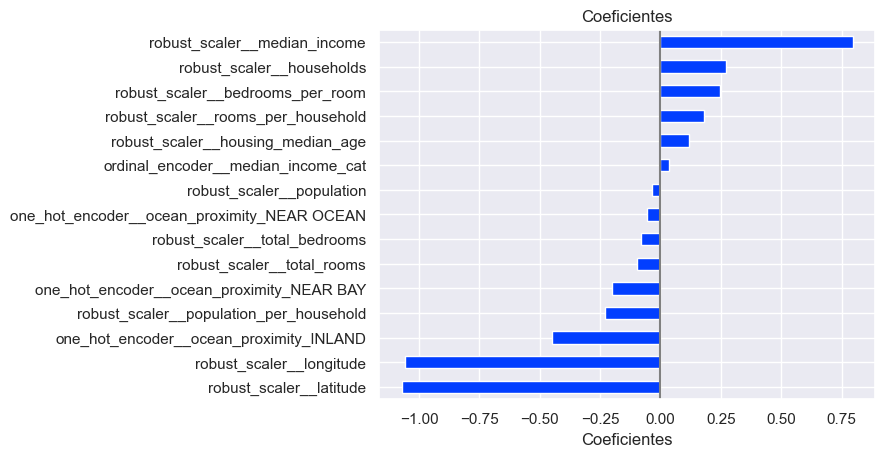

In [18]:
plot_coeficientes(coefs)

#### **Comparando os modelos acima criados com o modelo com os melhores estimadores pelo GridSearchCV**

In [19]:
regressors = {
    "DummyRegressor": {
        'preprocessor': None,
        'regressor': DummyRegressor(strategy='mean'),
        'target_transformer': None
    },
    "LinearRegression": {
        'preprocessor': preprocessamento_categoricas,
        'regressor': LinearRegression(),
        'target_transformer': None
    },
    "LinearRegression_GridSearchCV": {
        'preprocessor': grid_search.best_estimator_.regressor_['preprocessor'],
        'regressor': grid_search.best_estimator_.regressor_['reg'],
        'target_transformer': grid_search.best_estimator_.transformer
    }, 
}

In [20]:
resultados = {
    nome_modelo: treinar_e_validar_modelo_regressao(X, y, **regressor) for nome_modelo, regressor in regressors.items()
}

df_resultados = organiza_resultados(resultados)
df_resultados

,model,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
0,DummyRegressor,0.00798,0.007979,-0.000081,-77516.042766,-96239.705692,0.015959
1,DummyRegressor,0.005986,0.007975,-0.000146,-75787.787194,-95217.629397,0.013961
2,DummyRegressor,0.006013,0.010971,-0.001737,-76753.598961,-96253.253947,0.016984
3,DummyRegressor,0.007978,0.007979,-0.000101,-76837.804811,-95983.885799,0.015957
4,DummyRegressor,0.007012,0.007979,-0.000114,-76617.245449,-96182.764729,0.014991
5,LinearRegression,0.109222,0.018946,0.682162,-39855.690921,-54254.958115,0.128169
6,LinearRegression,0.174544,0.01673,0.66999,-40272.565406,-54695.230224,0.191274
7,LinearRegression,0.135643,0.017563,0.649247,-42178.059246,-56955.988686,0.153206
8,LinearRegression,0.121162,0.015955,0.669873,-40806.492452,-55146.31876,0.137116
9,LinearRegression,0.104961,0.014962,0.669023,-40788.496555,-55331.351171,0.119922


In [21]:
df_resultados.groupby('model').mean()

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
model,,,,,,
DummyRegressor,0.006994,0.008577,-0.000436,-76702.495836,-95975.447913,0.01557
LinearRegression,0.129106,0.016831,0.668059,-40780.260916,-55276.769391,0.145937
LinearRegression_GridSearchCV,0.151508,0.017852,0.678126,-38680.123202,-54427.955462,0.169359


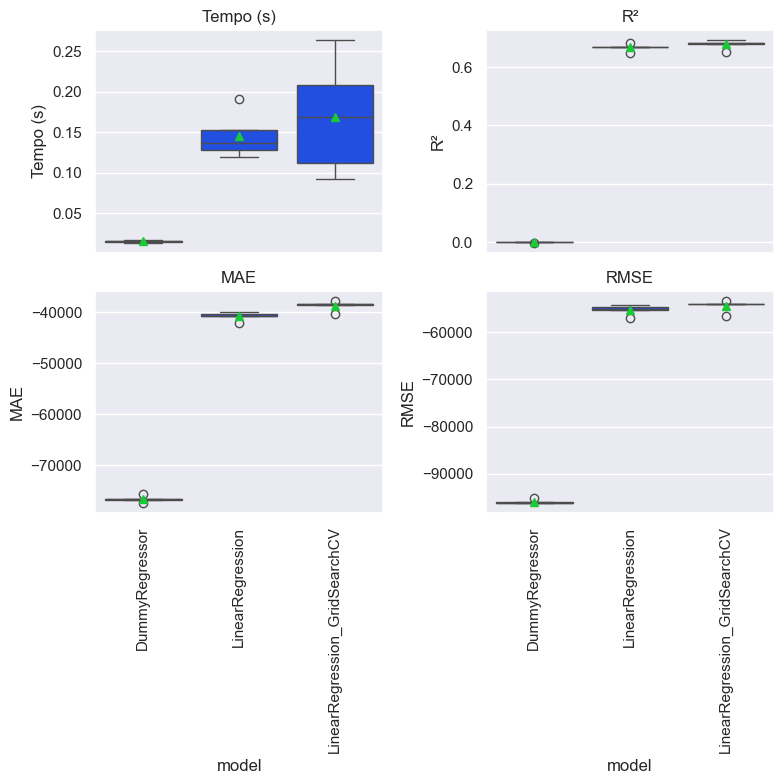

In [22]:
plot_comparar_metricas_modelos(df_resultados)         # Veja que os resultados obtido com o QuantileTrasnformer foram melhores, com menor tempo de execução do que com PowerTransformer